# 1. Setup

In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import StrMethodFormatter, MultipleLocator
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Local imports
from config import (LEADERBOARD_DATA, COMPLETIONS_DATA, SUBMISSION_TIMES_PLOT, USER_INFO_PLOT, 
                    PUBLIC_COMPLETION_PLOT_2, TOP100_ACCUMULATED_PLOT, TOP10_ACCUMULATED_PLOT, 
                    TOP10_ANNUAL_PLOT)


SAVEFIG = False


# Plot configurations
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

TEXT_COLOR = '#FFD700'
PRIMARY_COLOR = '#FF0000'
BACKGROUND_COLOR = '#04013b'
GRID_COLOR = 'white'

rc = {
    "axes.facecolor" : BACKGROUND_COLOR, 
    "axes.grid" : True,
    "axes.labelcolor" : TEXT_COLOR,
    "axes.spines.bottom" : False,
    "axes.spines.left" : False,
    "axes.spines.right" : False,
    "axes.spines.top" : False,
    "axes.titlesize" : 18,
    "axes.titleweight" : "bold",
    "boxplot.showmeans": True,
    "boxplot.boxprops.color": TEXT_COLOR,
    "boxplot.capprops.color": TEXT_COLOR,
    "boxplot.flierprops.markeredgecolor": BACKGROUND_COLOR,
    "boxplot.flierprops.markerfacecolor": TEXT_COLOR,
    "boxplot.meanprops.marker": 'o',
    "boxplot.meanprops.markeredgecolor": TEXT_COLOR,
    "boxplot.meanprops.markerfacecolor": PRIMARY_COLOR,
    "boxplot.patchartist" : True,
    "boxplot.whiskerprops.color": TEXT_COLOR,
    "figure.dpi" : 200,
    "figure.facecolor" : BACKGROUND_COLOR,
    "figure.titlesize" : 18,
    "figure.titleweight" : "bold",
    "font.family" : "serif",
    "grid.alpha" : 0.3,
    "grid.color" : GRID_COLOR,
    "grid.linestyle" : "--",
    "grid.linewidth" : 0.5,
    "legend.edgecolor" : GRID_COLOR, 
    "legend.framealpha" : 0.3,
    "patch.edgecolor" : "none",
    "scatter.edgecolors" : TEXT_COLOR,
    "text.color" : TEXT_COLOR,
    "xtick.bottom" : False,
    "xtick.color" : TEXT_COLOR,
    "ytick.color" : TEXT_COLOR,
    "ytick.left" : False,
}

plt.rcParams.update(rc)

# 2. Loading and Processing the Data

- **leaderboard** 
    - 45,000 rows ( = 9 years $\cdot$ 25 days $\cdot$ 2 parts $\cdot$ 100 ranks)
    - Year, day and submission time are condensed into a single timestamp and need to be unpacked
    - Contains some further information about each user (although not much)
    - Only needs to be updated once a year

    
- **completions**
    - 225 rows ( = 9 years $\cdot$ 25 days)
    - *gold*: number of times a player completed both part 1 *and* part 2
    - *silver:* number of times a player completed only part 1
    - *total:* 2 $\cdot$ *gold* + *silver*
    - These stats are less constant, because every day there are new completions coming in. I will therefore add a caption to all the completions as to the last time the stats were updated

In [2]:
# load and unpack leaderboard df
leaderboard = pd.read_csv(LEADERBOARD_DATA, parse_dates=['timestamp'])
leaderboard['year'] = leaderboard['timestamp'].dt.year
leaderboard['day'] = leaderboard['timestamp'].dt.day
leaderboard['seconds'] = leaderboard['timestamp'].apply(lambda dt: 3600*dt.hour + 60*dt.minute + dt.second)
leaderboard['rank'] = 101 - leaderboard['points']
leaderboard['anonymous'] = leaderboard.user_name.str.contains('anonymous')
leaderboard = leaderboard[['year', 'day', 'part', 'seconds', 'rank', 'points', 'user_name', 'supporter', 'sponsor', 'anonymous']]

# load and unpack leaderboard df
completions = pd.read_csv(COMPLETIONS_DATA)
completions['total'] = 2*completions.gold + completions.silver

# Display dfs
print('Leaderboard Dataframe (unpacked):')
display(leaderboard)
print('Completion Dataframe (unpacked):')
display(completions)

Leaderboard Dataframe (unpacked):


year  day  part  seconds  rank  points                  user_name  \
0      2015    1     2      655     1     100                  Aneurysm9   
1      2015    1     2      982     2      99               Joel Lathrop   
2      2015    1     2     1451     3      98            Igor Naverniouk   
3      2015    1     2     1487     4      97                Corey Maher   
4      2015    1     2     1494     5      96                Joe LeGasse   
...     ...  ...   ...      ...   ...     ...                        ...   
44995  2023   25     1      765    96       5                 Jeffrey H.   
44996  2023   25     1      779    97       4                  Yiming Li   
44997  2023   25     1      779    98       3  (anonymous user #2330367)   
44998  2023   25     1      784    99       2                     1e1001   
44999  2023   25     1      787   100       1               Borut Levart   

       supporter  sponsor  anonymous  
0           True    False      False  
1          False    False      False  
2          False    False      False  
3          False    False      False  
4          False    False      False  
...          ...      ...        ...  
44995      False    False      False  
44996      False    False      False  
44997      False    False       True  
44998      False    False      False  
44999      False    False      False  

[45000 rows x 10 columns]

Completion Dataframe (unpacked):


year  day                                   title   gold  silver   total
0    2015    1                          Not Quite Lisp  87682   17867  193231
1    2015    2       I Was Told There Would Be No Math  60863    6075  127801
2    2015    3  Perfectly Spherical Houses in a Vacuum  50547    4041  105135
3    2015    4              The Ideal Stocking Stuffer  43670    1464   88804
4    2015    5  Doesn't He Have Intern-Elves For This?  37714    6477   81905
..    ...  ...                                     ...    ...     ...     ...
220  2023   21                            Step Counter  13882   10073   37837
221  2023   22                              Sand Slabs  15386     982   31754
222  2023   23                             A Long Walk  14105    2962   31172
223  2023   24                  Never Tell Me The Odds  11355    4887   27597
224  2023   25                             Snowverload  10049    3036   23134

[225 rows x 6 columns]

# 3. Puzzle Completions

- Last update: 2024-01-08
- 19,016,811 stars have been attained on Advent of Code in total
- 9,978,376 part 1 completions
- 9,038,435 part 2 completions

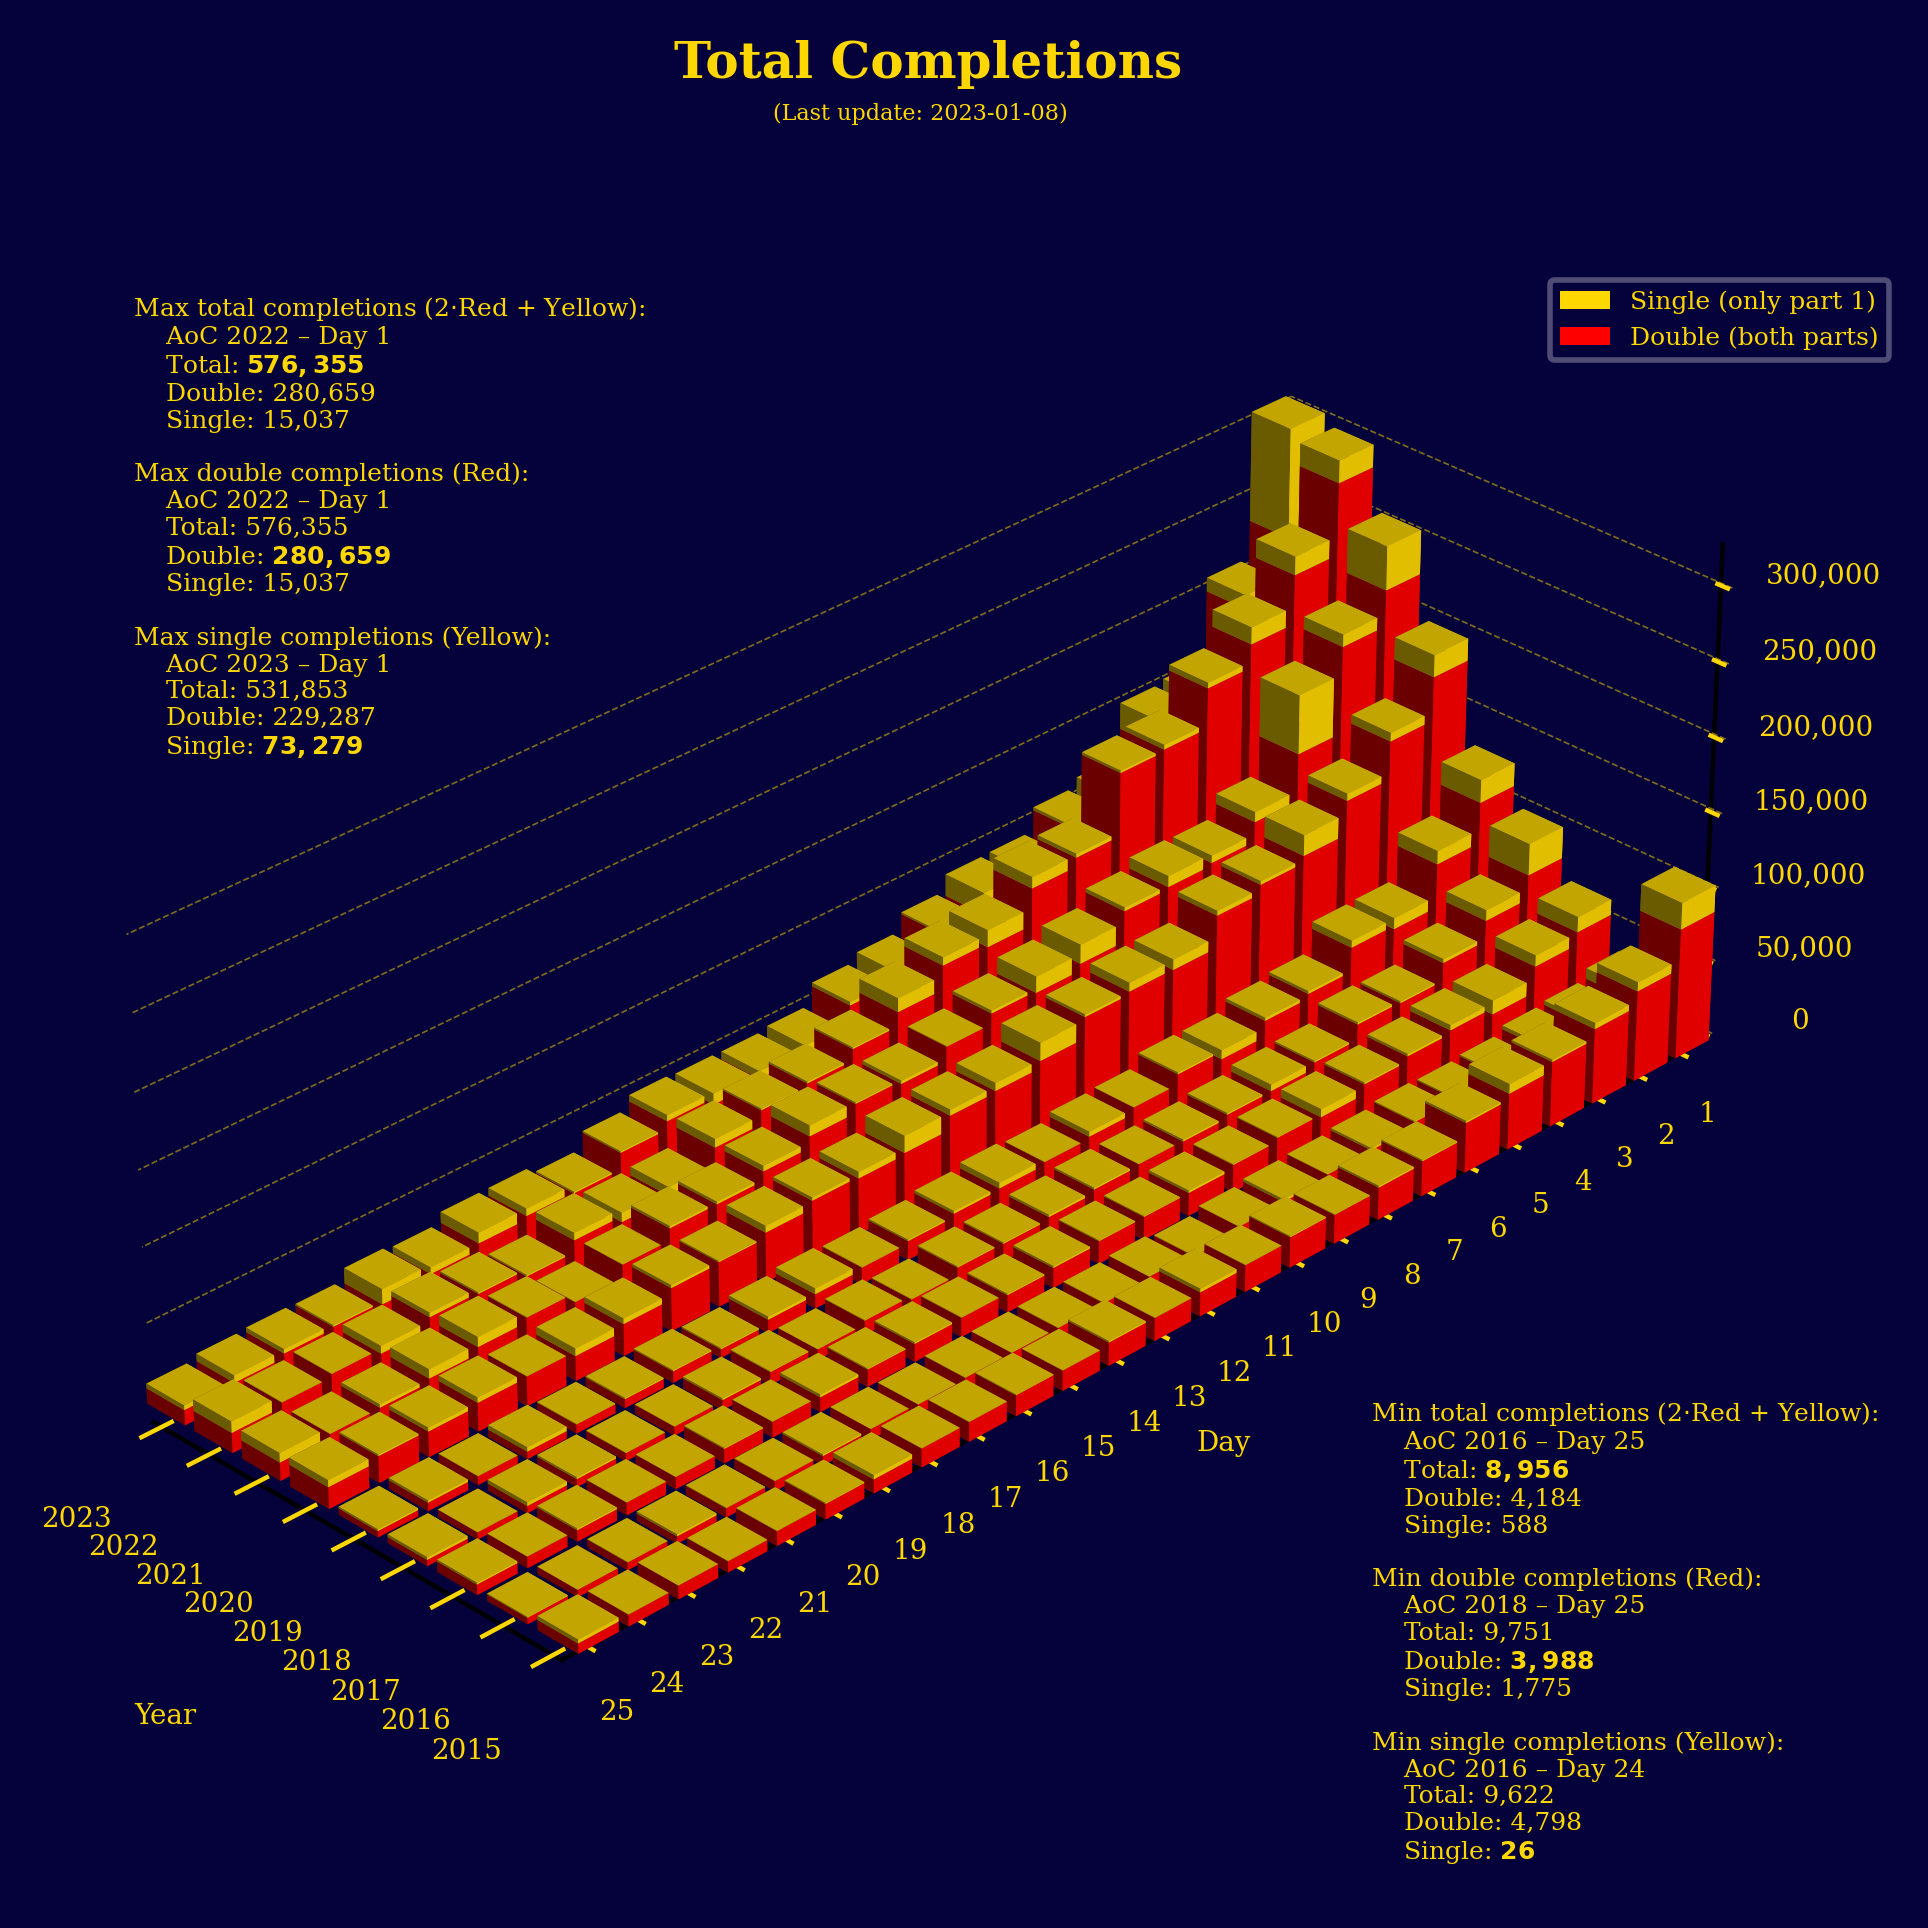

In [3]:
def get_formatted_texts(df):
    """Return formatted text blocks describing the puzzles with the lowest and highest values for single, double and total completion."""
    
    cols = ['year', 'day', 'total', 'gold', 'silver']
    max_total_year,  max_total_day,  max_total_total,  max_total_double,  max_total_single  = map(int, df.loc[df.total.idxmax(), cols])
    max_double_year, max_double_day, max_double_total, max_double_double, max_double_single = map(int, df.loc[df.gold.idxmax(), cols])
    max_single_year, max_single_day, max_single_total, max_single_double, max_single_single = map(int, df.loc[df.silver.idxmax(), cols])
    min_total_year,  min_total_day,  min_total_total,  min_total_double,  min_total_single  = map(int, df.loc[df.total.idxmin(), cols])
    min_double_year, min_double_day, min_double_total, min_double_double, min_double_single = map(int, df.loc[df.gold.idxmin(), cols])
    min_single_year, min_single_day, min_single_total, min_single_double, min_single_single = map(int, df.loc[df.silver.idxmin(), cols])

    max_text = f'''
    Max total completions (2$\cdot$Red + Yellow):
        AoC {max_total_year} – Day {max_total_day}
        Total: {format(max_total_total, True)}
        Double: {format(max_total_double)} 
        Single: {format(max_total_single)}

    Max double completions (Red): 
        AoC {max_double_year} – Day {max_double_day}
        Total: {format(max_double_total)}
        Double: {format(max_double_double, True)} 
        Single: {format(max_double_single)}

    Max single completions (Yellow): 
        AoC {max_single_year} – Day {max_single_day}
        Total: {format(max_single_total)}
        Double: {format(max_single_double)} 
        Single: {format(max_single_single, True)}'''

    min_text = f'''
    Min total completions (2$\cdot$Red + Yellow):
        AoC {min_total_year} – Day {min_total_day}
        Total: {format(min_total_total, True)}
        Double: {format(min_total_double)}
        Single: {format(min_total_single)}

    Min double completions (Red): 
        AoC {min_double_year} – Day {min_double_day}
        Total: {format(min_double_total)}
        Double: {format(min_double_double, True)} 
        Single: {format(min_double_single)}

    Min single completions (Yellow): 
        AoC {min_single_year} – Day {min_single_day}
        Total: {format(min_single_total)}
        Double: {format(min_single_double)} 
        Single: {format(min_single_single, True)}'''
    
#     update_text = f'(Last update: {datetime.now().strftime("%Y-%m-%d")})'
    update_text = '(Last update: 2023-01-08)'
    return max_text, min_text, update_text



def format(num: int, bold=False) -> str:
    """Uses MathTeX syntax for printing bold."""
    
    num = f'{num:,}'
    if bold:
        num =  r'$\mathbf{' + num + '}$'
    return num


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.set_title('Total Completions', fontsize=9)
ax.set_xlim(2023, 2015)
ax.set_ylim(25, 1)
ax.set_zlim(0, 320_000)
ax.set_yticks(range(1, 26))

ax.set_xlabel('Year', fontsize=(labelsize:=5))
ax.set_ylabel('Day', fontsize=labelsize)

ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.tick_params(axis='z', labelsize=labelsize)
ax.zaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.xaxis.set_pane_color(BACKGROUND_COLOR)
ax.yaxis.set_pane_color(BACKGROUND_COLOR)
ax.zaxis.set_pane_color(BACKGROUND_COLOR)
ax.grid(False)

linestyle = {'color': TEXT_COLOR, 'linewidth': 0.3, 'linestyle': '--', 'alpha': 0.5}
for z in np.linspace(0, 300_000, 7):
    ax.plot3D([2023.8]*2, [0, 25], [z-11000]*2, **linestyle)
    ax.plot3D([2015, 2023.8], [0]*2, [z-11000]*2, **linestyle)

for year in range(2023, 2014, -1):
    xs = completions[completions['year']==year]['year']
    ys = completions[completions['year']==year]['day']

    z_gold = completions[completions['year']==year]['gold']
    z_silver = completions[completions['year']==year]['silver']

    dx = dy = .8
    ax.bar3d(xs-dx/2, ys-dy/2, [0]*len(z_gold), dx, dy, z_gold, color='red')
    ax.bar3d(xs-dx/2, ys-dy/2, z_gold, dx, dy, z_silver, color=TEXT_COLOR)

ax.set_box_aspect([1,2.77777,1])
ax.view_init(elev=30, azim=-45)

legend_elements = [Patch(facecolor=TEXT_COLOR, label='Single (only part 1)'),
                   Patch(facecolor='red', label='Double (both parts)')]
ax.legend(handles=legend_elements, loc=(0.85, 0.86), fontsize=4.5)

max_text, min_text, update_text = get_formatted_texts(completions)
ax.text(2040, 11, -50_000, max_text, fontsize=4.5)
ax.text(2012, 12, -330_000, min_text, fontsize=4.5)
ax.text(2036, -1, 300_000, update_text, fontsize=4)

plt.tight_layout()


- Puzzle completions decrease per day as puzzles get harder
- Puzzle completions increase per year, although 2015 and 2023 currently break this trend
- The relatively low completions of 2023 can be explained by the recency of the event
- The relatively high completions of 2015 can probably be explained in two ways:
    1. people are curious to see how it all started
    2. people are planning to do all of the years in chronological order, but haven't gotten very far yet 
- There is a significant jump from 2019 to 2020 where completions double – I wonder if this can partially be explained by the Covid lockdowns (although they happened in 2020 before the event, so maybe not)

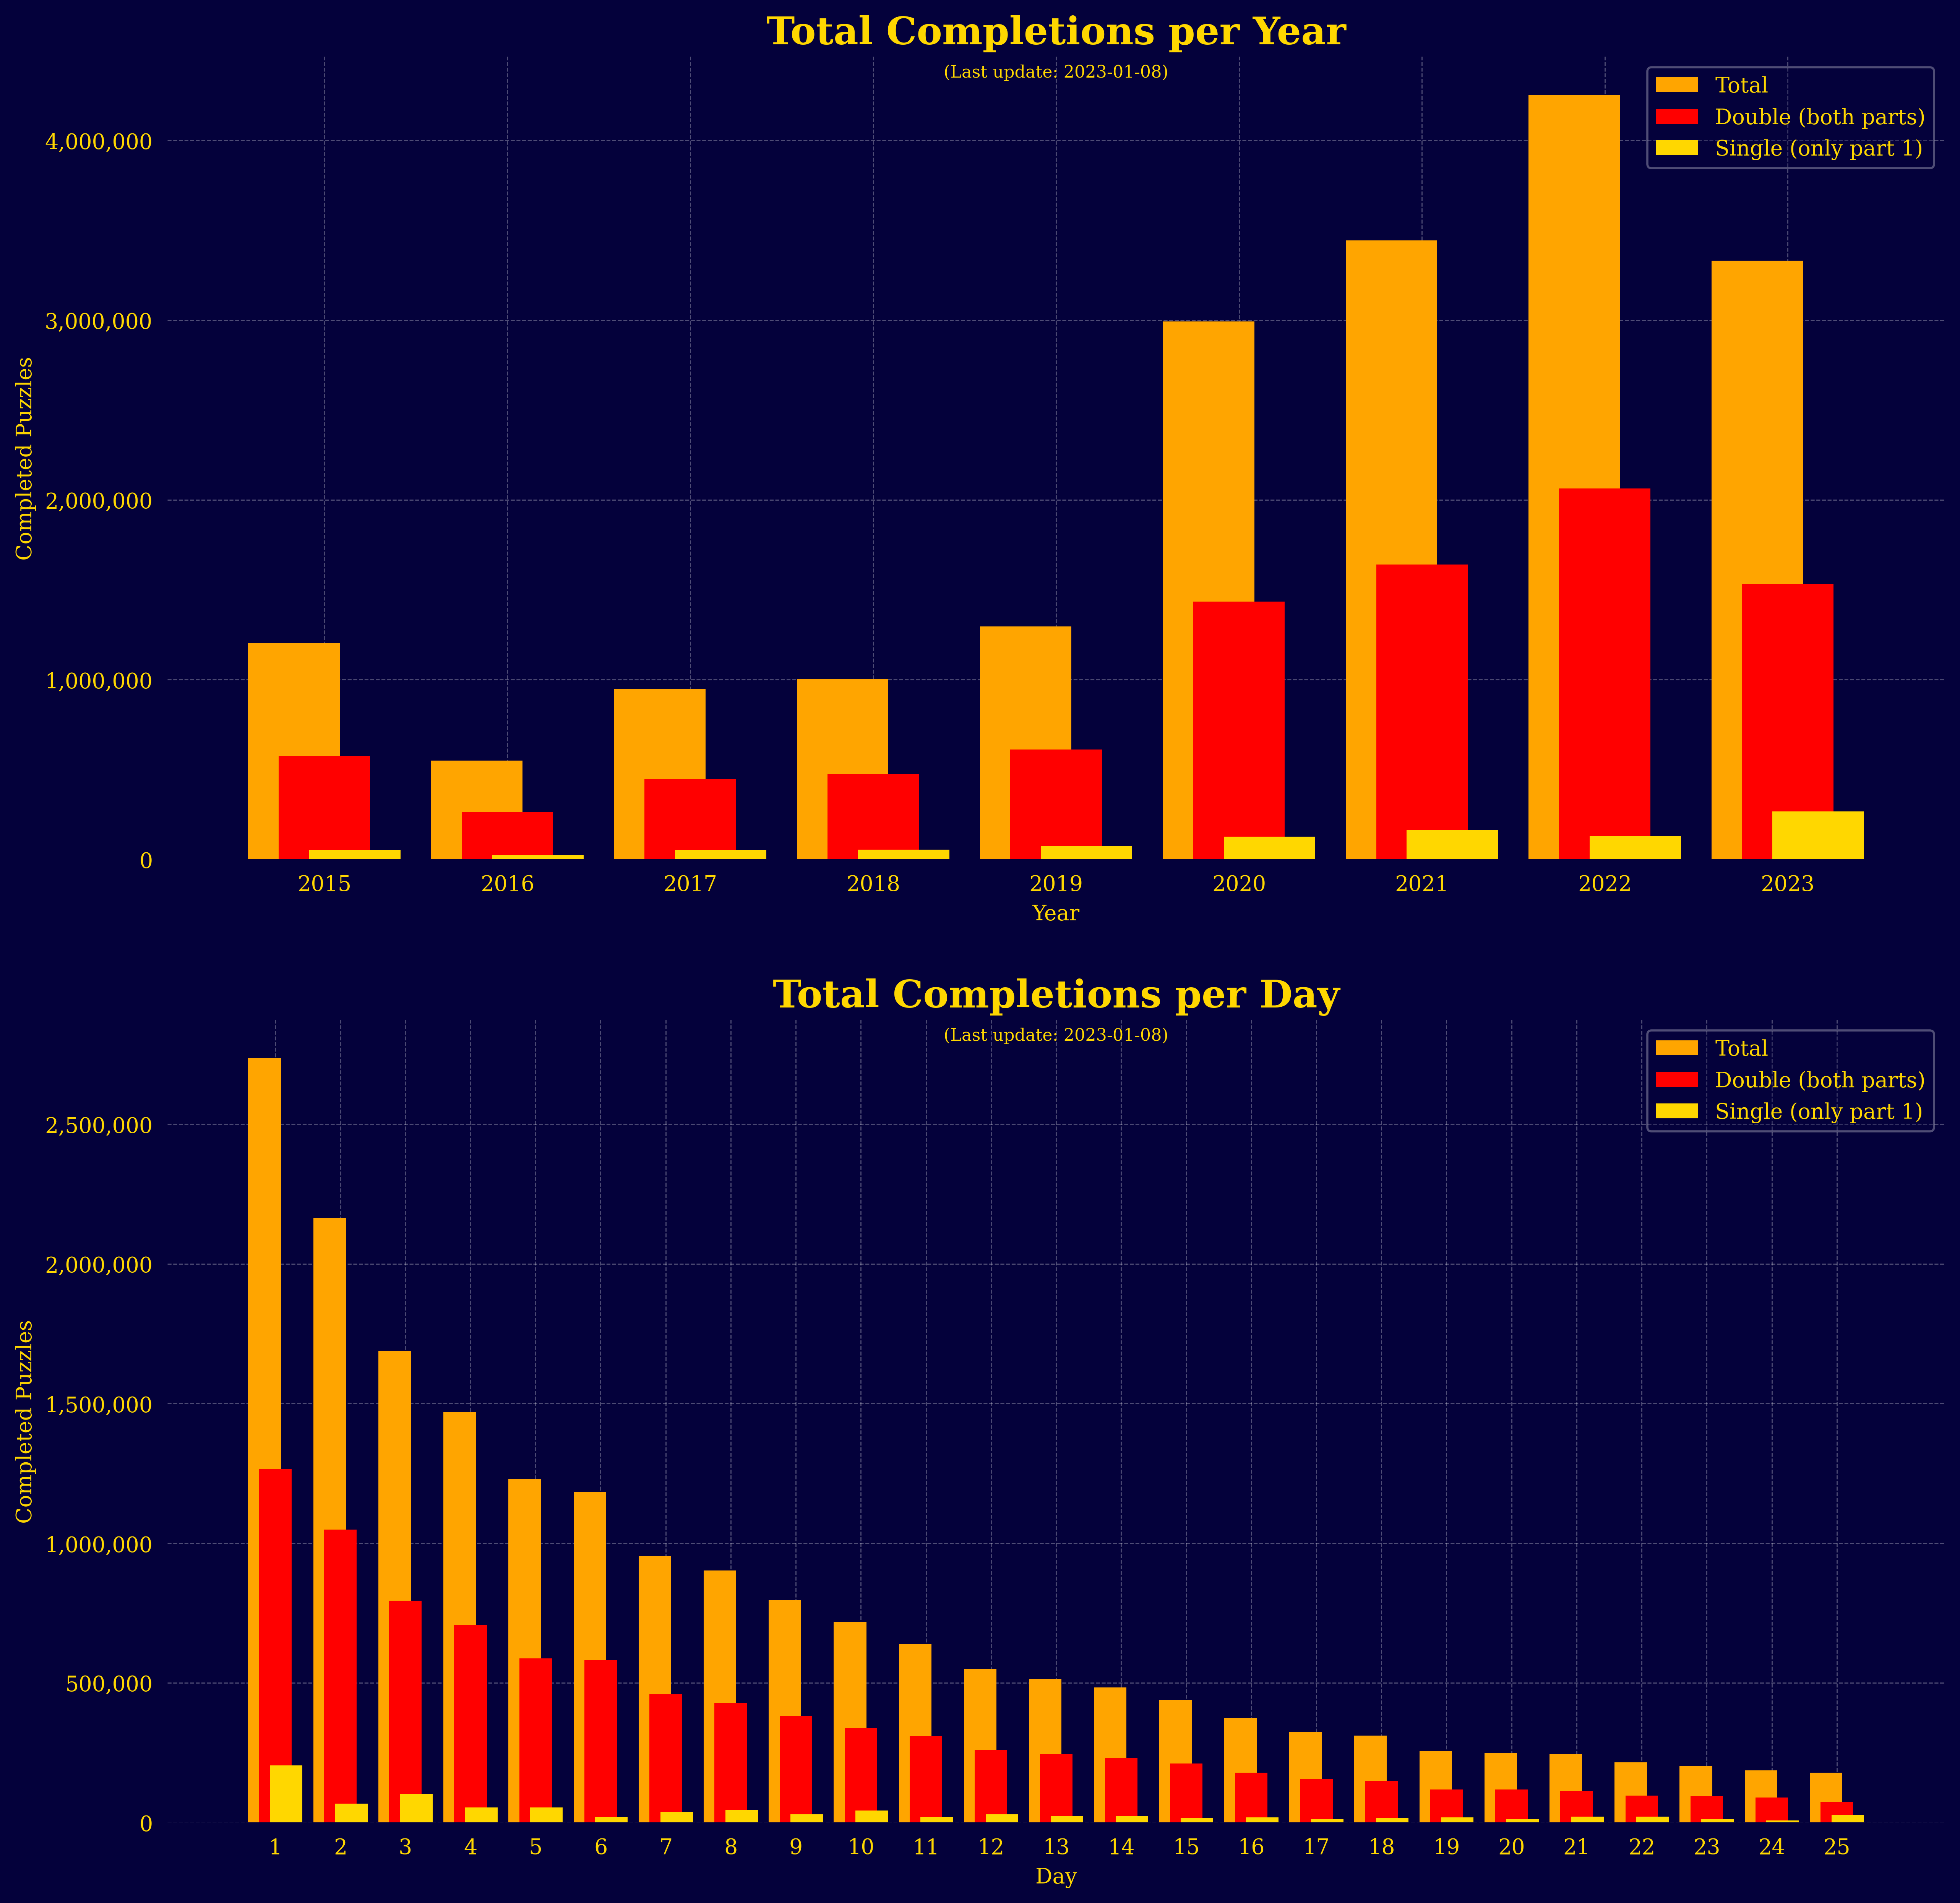

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
width = 0.5

# plot completions per year
years = completions.groupby('year')[['gold', 'silver', 'total']].agg('sum').reset_index()
ax1.bar(years.year-width/3, years.total, width=width, zorder=2, color='orange', label='Total')
ax1.bar(years.year, years.gold, width=width, zorder=2, color=PRIMARY_COLOR, label='Double (both parts)')
ax1.bar(years.year+width/3, years.silver, width=width, zorder=2, color=TEXT_COLOR, label='Single (only part 1)')
ax1.set_title('Total Completions per Year')
ax1.text(2019, 4_350_000, '(Last update: 2023-01-08)', fontsize=8, ha='center')
ax1.set_xticks(range(2015, 2024))
yticks = range(0, 4_000_001, 1_000_000)
ylabels = [f'{x:,}' for x in yticks]
ax1.set_yticks(yticks, ylabels)
ax1.set_xlabel('Year')
ax1.set_ylabel('Completed Puzzles')
ax1.legend()

# plot completions per day (over all years)
days = completions.groupby('day')[['gold', 'silver', 'total']].agg('sum').reset_index()
ax2.bar(days.day-width/3, days.total, width=width, zorder=2, color='orange', label='Total')
ax2.bar(days.day, days.gold, width=width, zorder=2, color=PRIMARY_COLOR, label='Double (both parts)')
ax2.bar(days.day+width/3, days.silver, width=width, zorder=2, color=TEXT_COLOR, label='Single (only part 1)')
ax2.set_title('Total Completions per Day')
ax2.text(13, 2_800_000, '(Last update: 2023-01-08)', fontsize=8, ha='center')
ax2.set_xticks(range(1, 26))
yticks = range(0, 2_500_001, 500_000)
ylabels = [f'{x:,}' for x in yticks]
ax2.set_yticks(yticks, ylabels)
ax2.set_xlabel('Day')
ax2.set_ylabel('Completed Puzzles')
ax2.legend();

if SAVEFIG:
    plt.savefig(PUBLIC_COMPLETION_PLOT_2)


# 4. Submission Times


- On average the first leaderboard entry occurs around 7 minutes for part 2 (4 minutes for part 1)
- On average it takes a bit less than 30 minutes for the leaderboard to fill up for part 2 (16 minutes for part 1)
- However, these numbers vary strongly across the 25 days
- Day 22 has the highest mean submission time: 46 minutes (part 2)
- The longest it ever took to fill up the leaderboard was day 19, 2015: 3 hours and 52 minutes
- There are 3 leaderboard entries under 20 seconds (*highly sus if you ask me...*):
    1. 2022–3–1: 10 seconds by ostwilkens 
    2. 2023–1–1: 12 seconds by (anonymous user #640116)
    3. 2022–4–1: 16 seconds by max-sixty

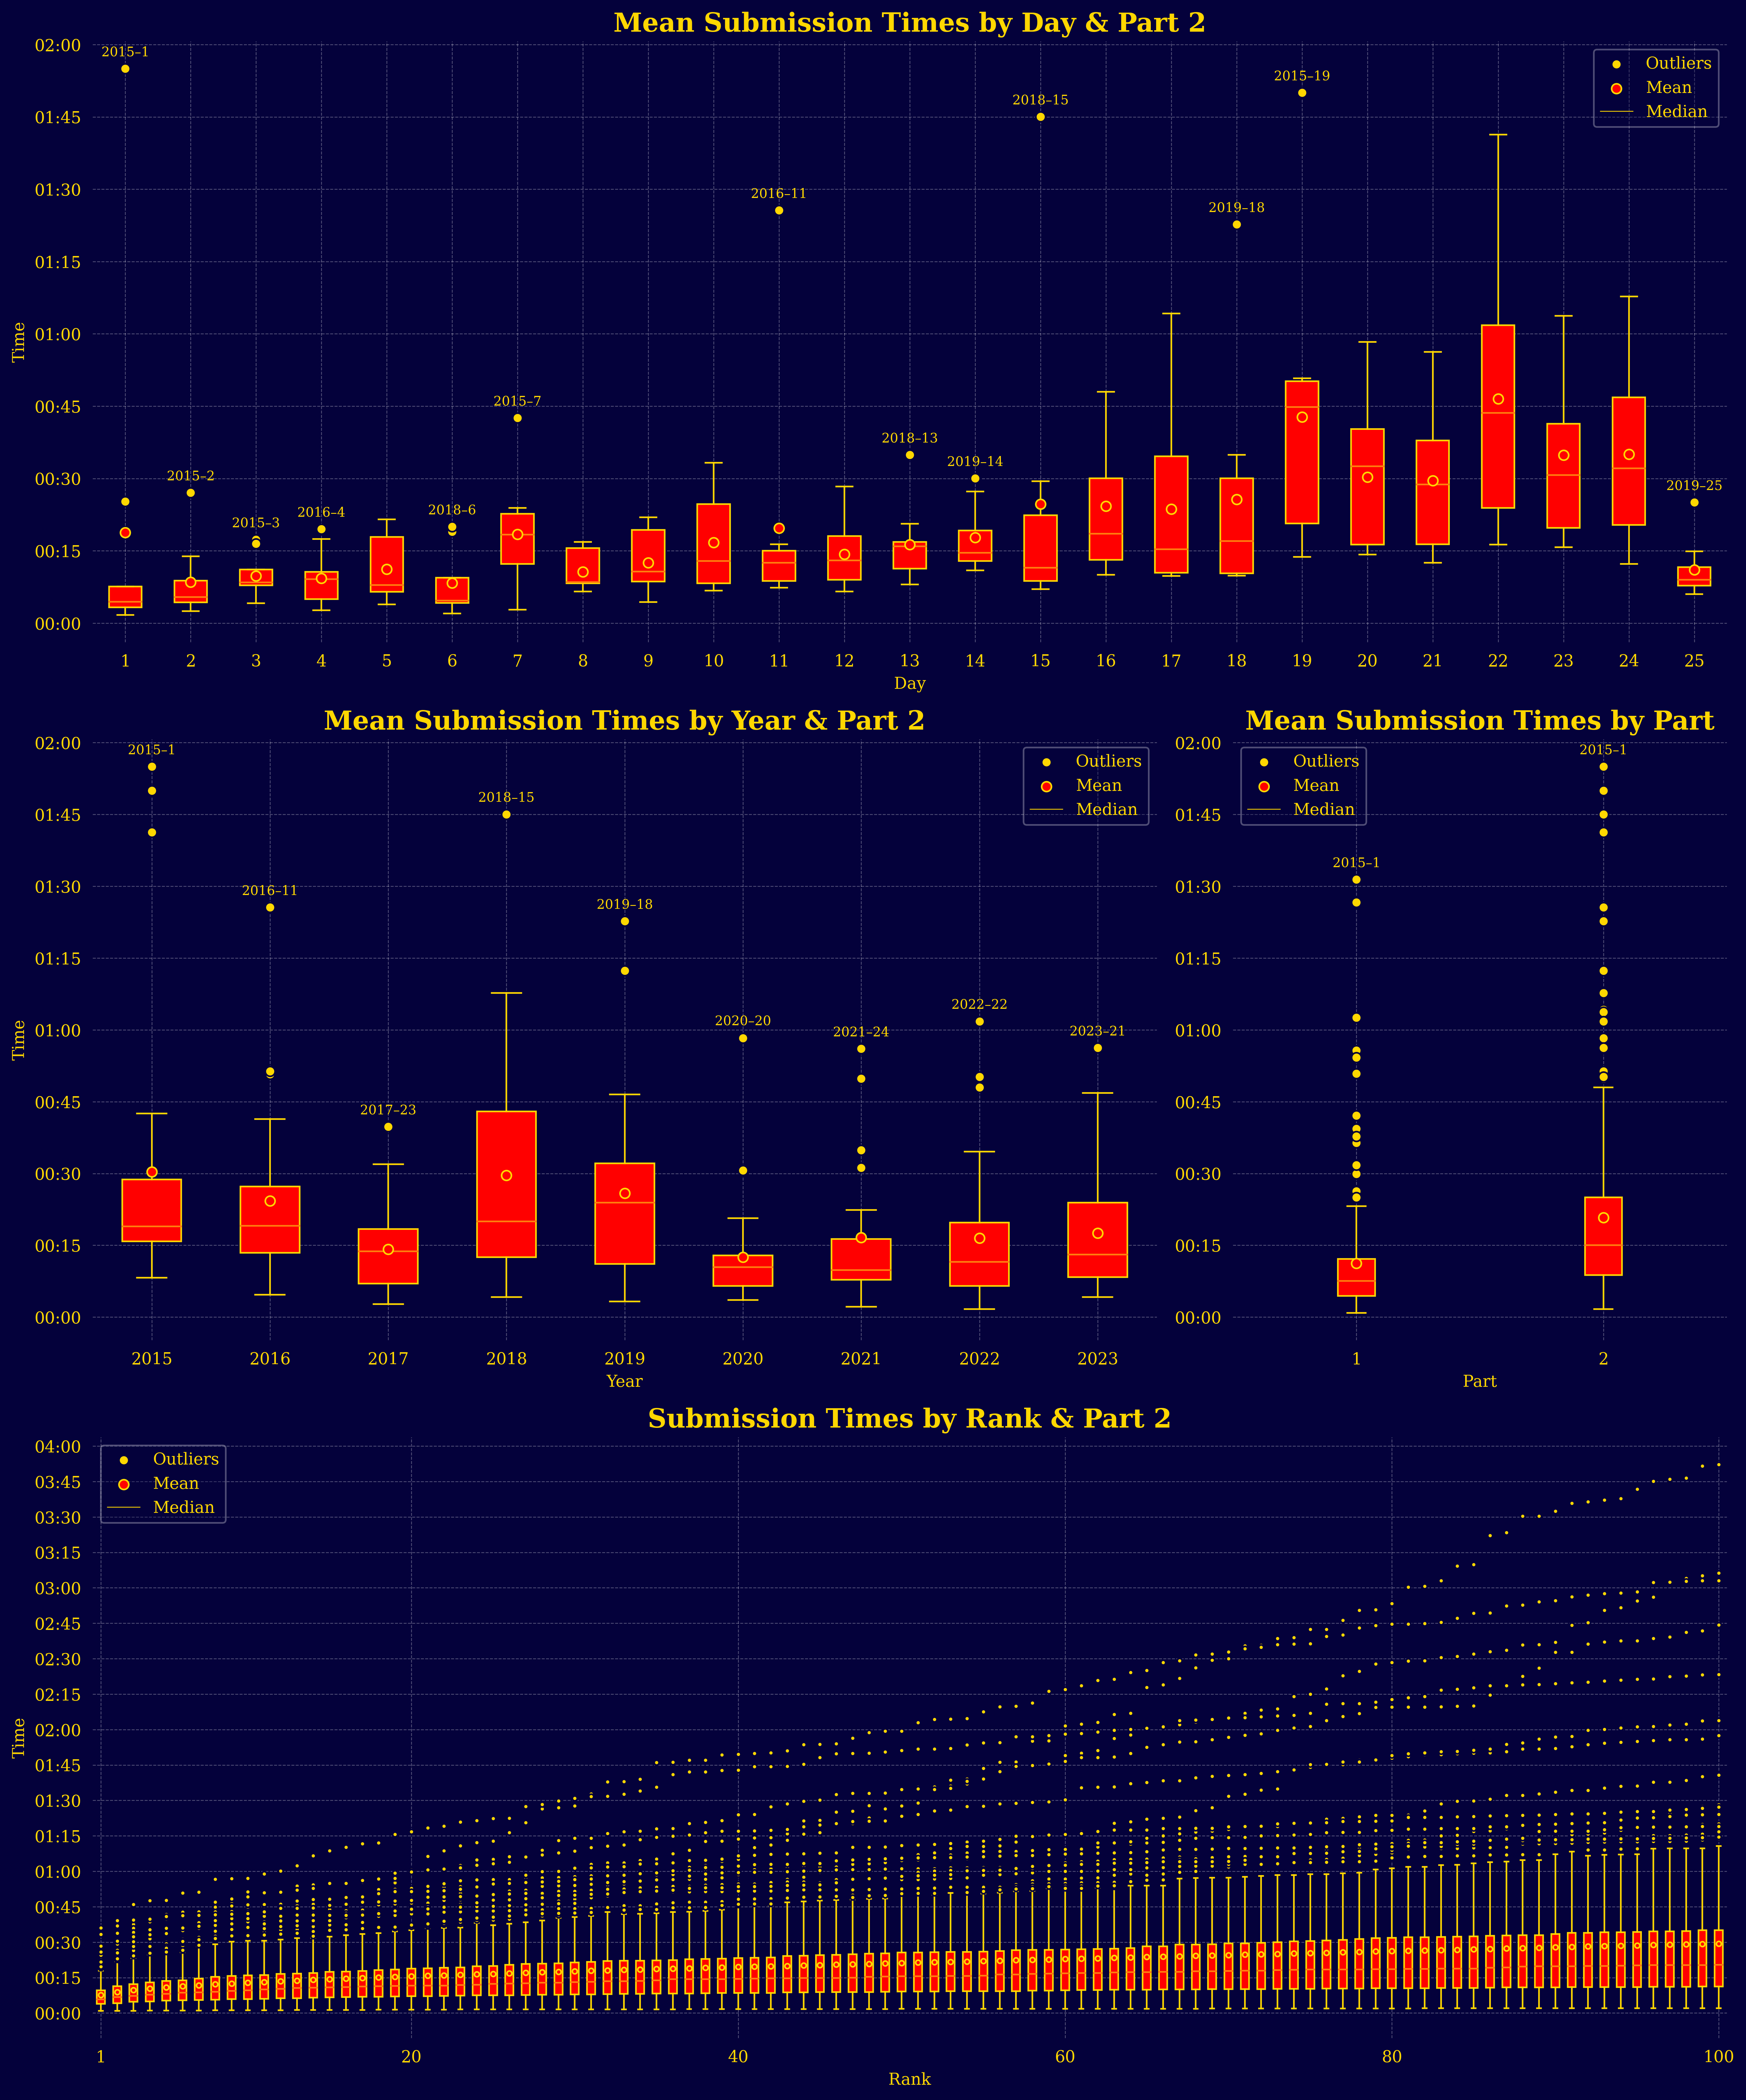

In [5]:
def prepare_data_for_boxplot(group_level):
    """Returns values, labels and annotations for given level of analysis."""
    if group_level == 'rank':  
        df = leaderboard.groupby(['year', 'day', 'part', 'rank'])['seconds'].agg(['mean'])
    else:
        df = leaderboard.groupby(['year', 'day', 'part'])['seconds'].agg(['mean'])
    if group_level != 'part':         # if not specifically comparing part 1 vs 2, use only part 2 data
        df = df.xs(2, level='part')        
    labels, values, annotations = [], [], []
    for label, data in df['mean'].groupby(level=group_level):
        labels.append(label)
        values.append(data.values)
        if group_level == 'rank':
            continue
        Q1 = np.percentile(data.values, 25)
        Q3 = np.percentile(data.values, 75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[data>upper_bound]
        if outliers.empty:
            continue
        index, y = max(outliers.items(), key=lambda x: x[1])
        if group_level == 'day':
            x, s = index[1], f'{index[0]}–{index[1]}'
        elif group_level == 'year':
            x, s = index[0]-2014, f'{index[0]}–{index[1]}'
        else:
            x, s = index[2], f'{index[0]}–{index[1]}'
        annotations.append((s, x, y))
        
    return values, labels, annotations


def format_time(seconds: int, tick_number: int | None = None) -> str:
    """Convert seconds integer into hours and minutes string HH:MM"""
    hours = seconds // 3600
    minutes = seconds % 3600 // 60
    return f'{hours:02.0f}:{minutes:02.0f}'


# Create figure, GridSpec layout and axes
fig = plt.figure(figsize=(15, 18))
gs = gridspec.GridSpec(3, 3)                    # 3 rows, 3 columns
ax1 = fig.add_subplot(gs[0, :])                 # Spans all 3 columns in the first row
ax2 = fig.add_subplot(gs[1, :2])                # Spans first 2 columns in the second row
ax3 = fig.add_subplot(gs[1, 2], sharey=ax2)     # Spans last column in the second row
ax4 = fig.add_subplot(gs[2, :])

# Plot each group level on its axis
for ax, group_level in zip((ax1, ax2, ax3, ax4), ('day', 'year', 'part', 'rank')):
    data, labels, annotations = prepare_data_for_boxplot(group_level)
    markerprops = {'markersize': 3} if group_level == 'rank' else {}
    for box in ax.boxplot(data, labels=labels, flierprops=markerprops, meanprops=markerprops)['boxes']:
        box.set_facecolor(PRIMARY_COLOR)
    title = f'{"Mean " if group_level!="rank" else ""}Submission Times by {group_level.capitalize()}'
    if group_level != 'part':
        title += ' & Part 2'
        ax.set_ylabel('Time')
    ax.set_title(title, size=16)
    ax.set_xlabel(group_level.capitalize())
    ax.yaxis.set_major_locator(MultipleLocator(900))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_time))
    for s, x, y in annotations:
        ax.annotate(s, (x, y), size=8, textcoords="offset points", xytext=(0,10), ha='center', va='center')
    ax.scatter([], [], marker='o', facecolor=TEXT_COLOR, edgecolor=BACKGROUND_COLOR, label='Outliers')
    ax.scatter([], [], marker='o', facecolor=PRIMARY_COLOR, edgecolor=TEXT_COLOR, label='Mean')
    ax.plot([], [], linewidth=0.5, color=TEXT_COLOR, label='Median')
    ax.legend()

# Modify x–axis of final plot and adjust layout
xticks = [1] + list(range(20, 101, 20))
ax4.set_xticks(xticks, xticks)
plt.tight_layout()

if SAVEFIG:
    plt.savefig(SUBMISSION_TIMES_PLOT)

# 5. User Stats

- 5,460 users in total on the leaderboard
- Somewhat significant but weak positive correlation between having a high number of total accumulated points and being a supporter
- Much weaker (perhaps insignificant) correlations between one's points and being a sponsor (pos) or participating anonymously (neg)
- For the last two years there have been just as many old users on the leaderboard as new users 

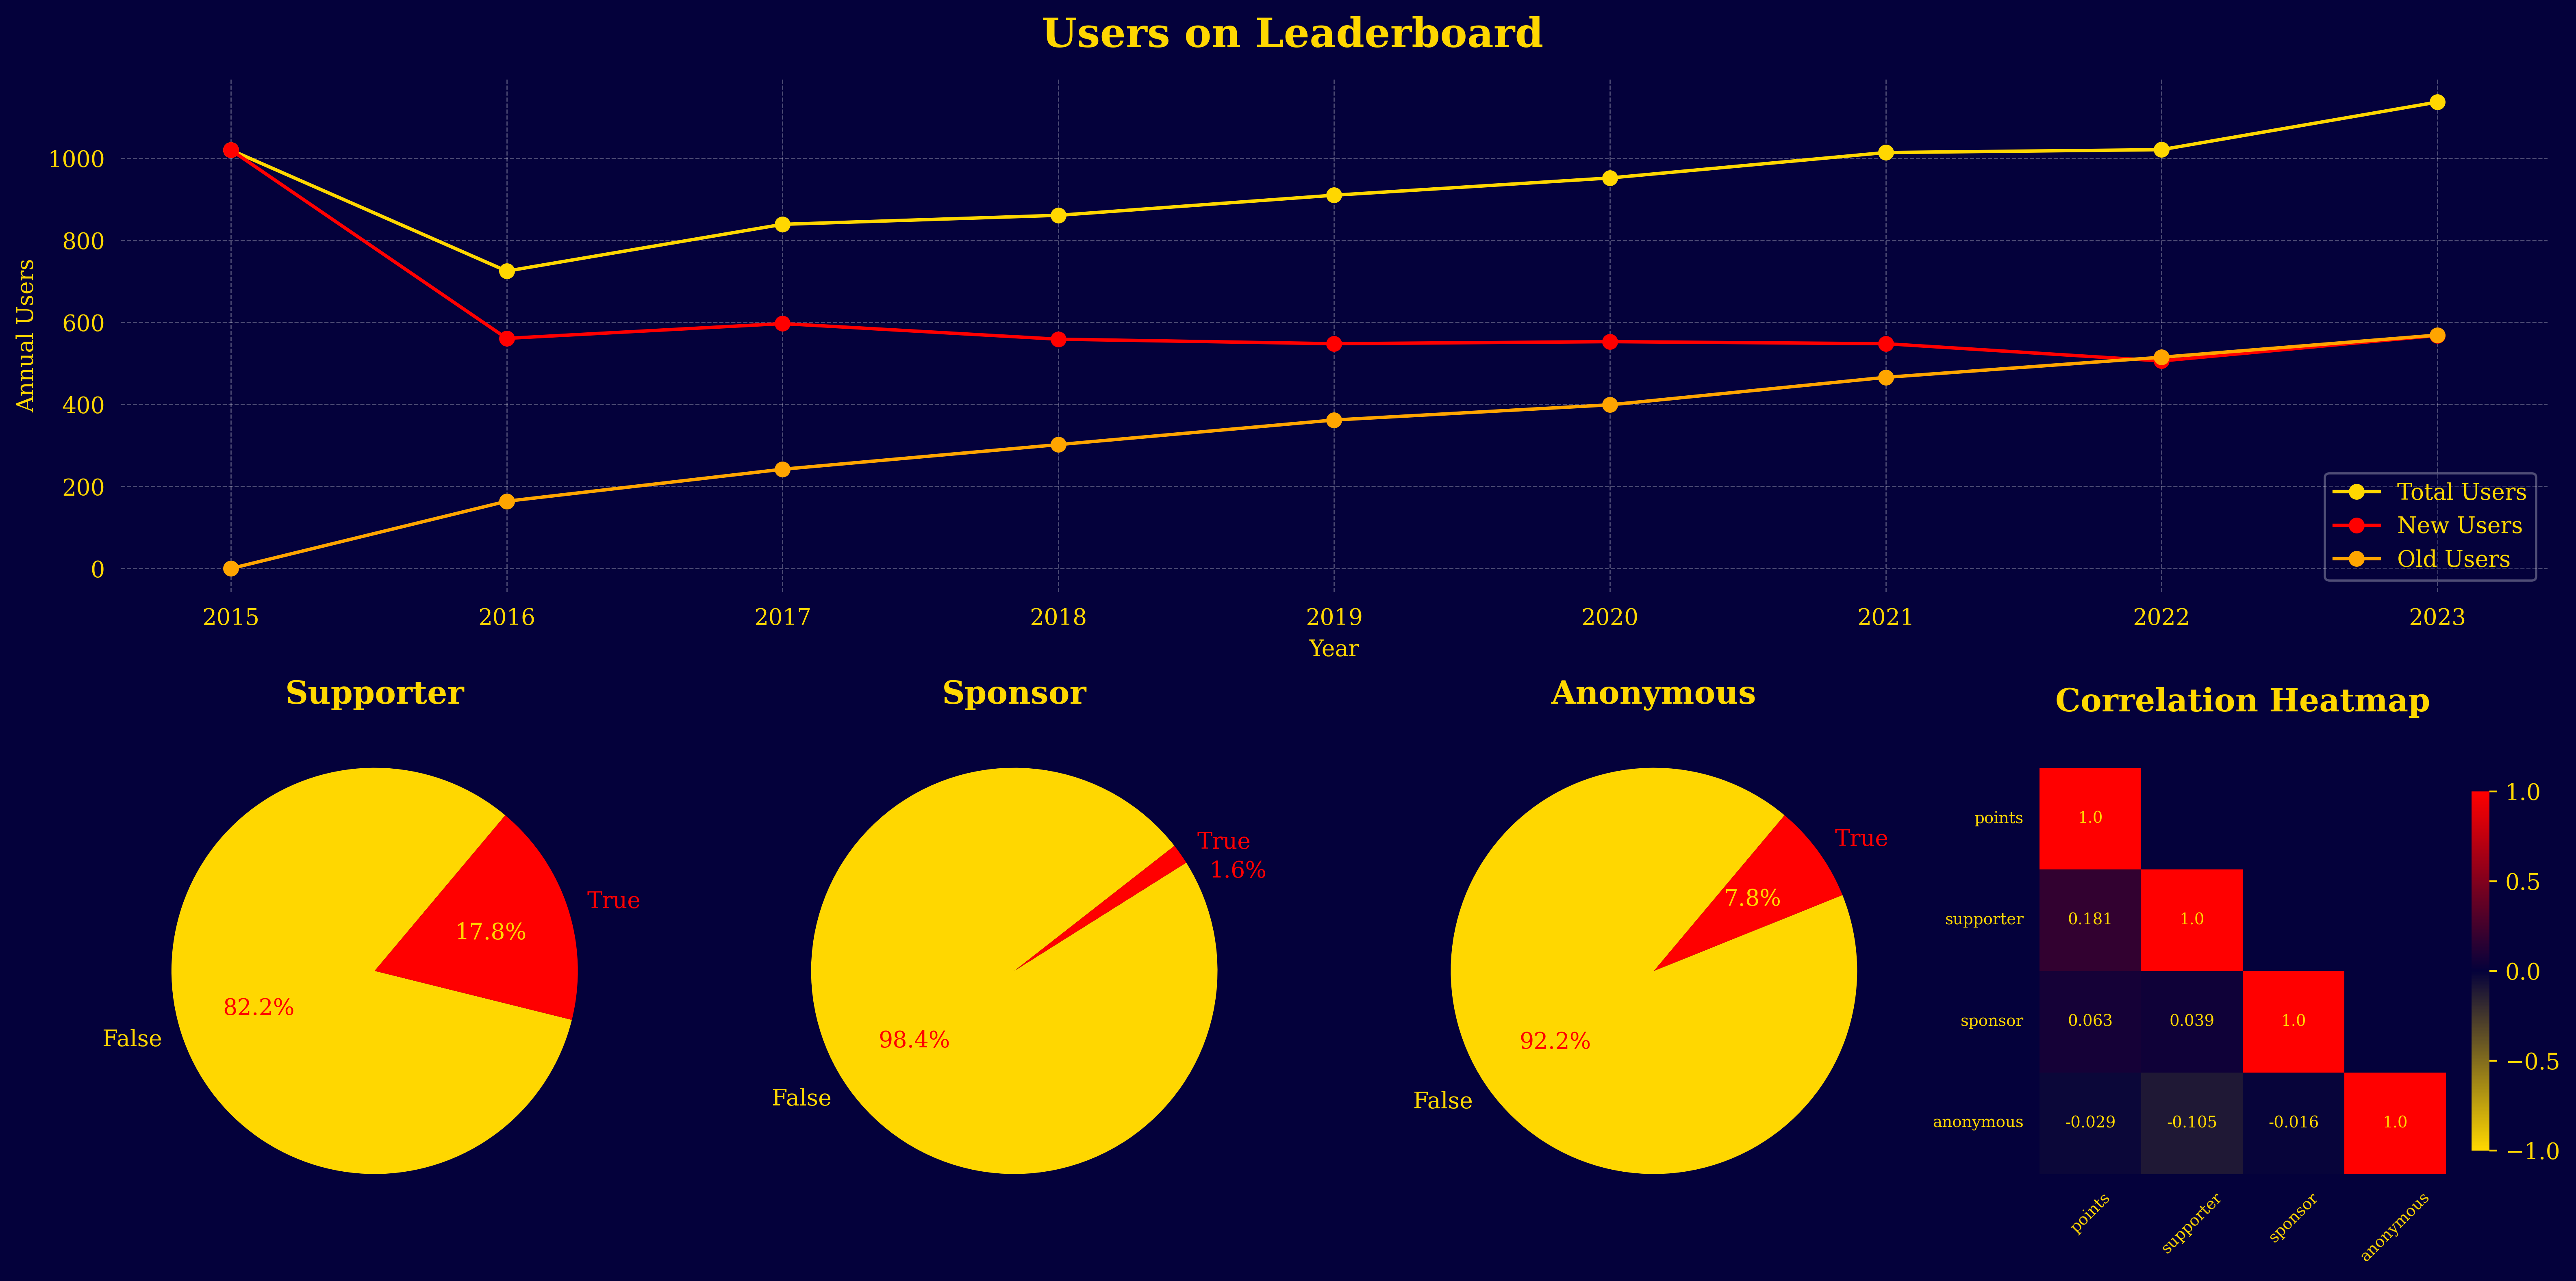

In [6]:
# Prepare data
users = leaderboard.groupby('user_name').agg({'points': 'sum', 'supporter': any, 'sponsor': any, 'anonymous': any})
users = users.sort_values(by='points', ascending=False)

# Create figure, GridSpec layout and axes
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Users on Leaderboard')
gs = gridspec.GridSpec(2, 4)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[1, 3])

# Annual leaderboard user growth plot
annual_total_users = []
annual_new_users = []
annual_old_users = []
prev_users = set()
for year in range(2015, 2024):
    all_users = set(leaderboard[leaderboard.year==year].user_name)
    new_users = len(all_users.difference(prev_users))
    prev_users |= all_users
    annual_total_users.append(len(all_users))
    annual_new_users.append(new_users)
    annual_old_users.append(len(all_users) - new_users)
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual Users')
# ax1.set_ylim(0, 1250)
ax1.plot(range(2015, 2024), annual_total_users, marker='o', color=TEXT_COLOR, label='Total Users')
ax1.plot(range(2015, 2024), annual_new_users, marker='o', color=PRIMARY_COLOR, label='New Users')
ax1.plot(range(2015, 2024), annual_old_users, marker='o', color='orange', label='Old Users')
ax1.legend()

# Supporter pie chart
supporter = users.supporter.value_counts()
text, autotext = ax2.pie(supporter, labels=supporter.index, autopct='%1.1f%%', startangle=50, colors=[TEXT_COLOR, PRIMARY_COLOR])[1:]
text[1].set_color(PRIMARY_COLOR)
autotext[0].set_color(PRIMARY_COLOR)
ax2.set_title('Supporter', size=14)

# Sponsor pie chart
sponsor = users.sponsor.value_counts()
text, autotext = ax3.pie(sponsor, labels=sponsor.index, autopct='%1.1f%%', startangle=38, colors=[TEXT_COLOR, PRIMARY_COLOR])[1:]
text[1].set_color(PRIMARY_COLOR)
autotext[0].set_color(PRIMARY_COLOR)
autotext[1].set_color(PRIMARY_COLOR)
autotext[1].set_position((1.1, autotext[1].get_position()[0]))
ax3.set_title('Sponsor', size=14)

# Anonymous pie chart
anon = users.anonymous.value_counts()
text, autotext = ax4.pie(anon, labels=anon.index, autopct='%1.1f%%', startangle=50, colors=[TEXT_COLOR, PRIMARY_COLOR])[1:]
text[1].set_color(PRIMARY_COLOR)
autotext[0].set_color(PRIMARY_COLOR)
ax4.set_title('Anonymous', size=14)

# Correlation matrix
corr_matrix = users.corr()
mask = np.triu(np.ones_like(corr_matrix), k=1)
annot = corr_matrix.round(3).astype(str)
cmap = LinearSegmentedColormap.from_list('custom_cmap', [TEXT_COLOR, BACKGROUND_COLOR, PRIMARY_COLOR])
cbar_kws = {'shrink': 0.7}
annot_kws = {"size": 7, 'color': TEXT_COLOR}
sns.heatmap(corr_matrix, ax=ax5, mask=mask, annot=annot, annot_kws=annot_kws, cbar_kws=cbar_kws, vmin=-1, vmax=1, cmap=cmap, fmt='', square=True)
ax5.grid(False)
ax5.tick_params(axis='both', labelsize=7)
ax5.tick_params(axis='x', rotation=45)
ax5.set_title("Correlation Heatmap", pad=25, size=14)

plt.tight_layout()
if SAVEFIG:
    plt.savefig(USER_INFO_PLOT)

*Anonymity*
- Anonymous AoC'ers are almost equally as likely to have high performances and be financially supportive
- 5 among the top 100 AoC-ers are anonymous, which is only slightly subproportional (they represent 7.8% of the total leaderboard)
- The highest annual score ever achieved was by an anonymous user
- Why be anonymous? Perhaps they don't seek fame at all and are just in it for the love of the game. Perhaps they don't want their bosses finding out, what they spend much of their productive energy on :-P

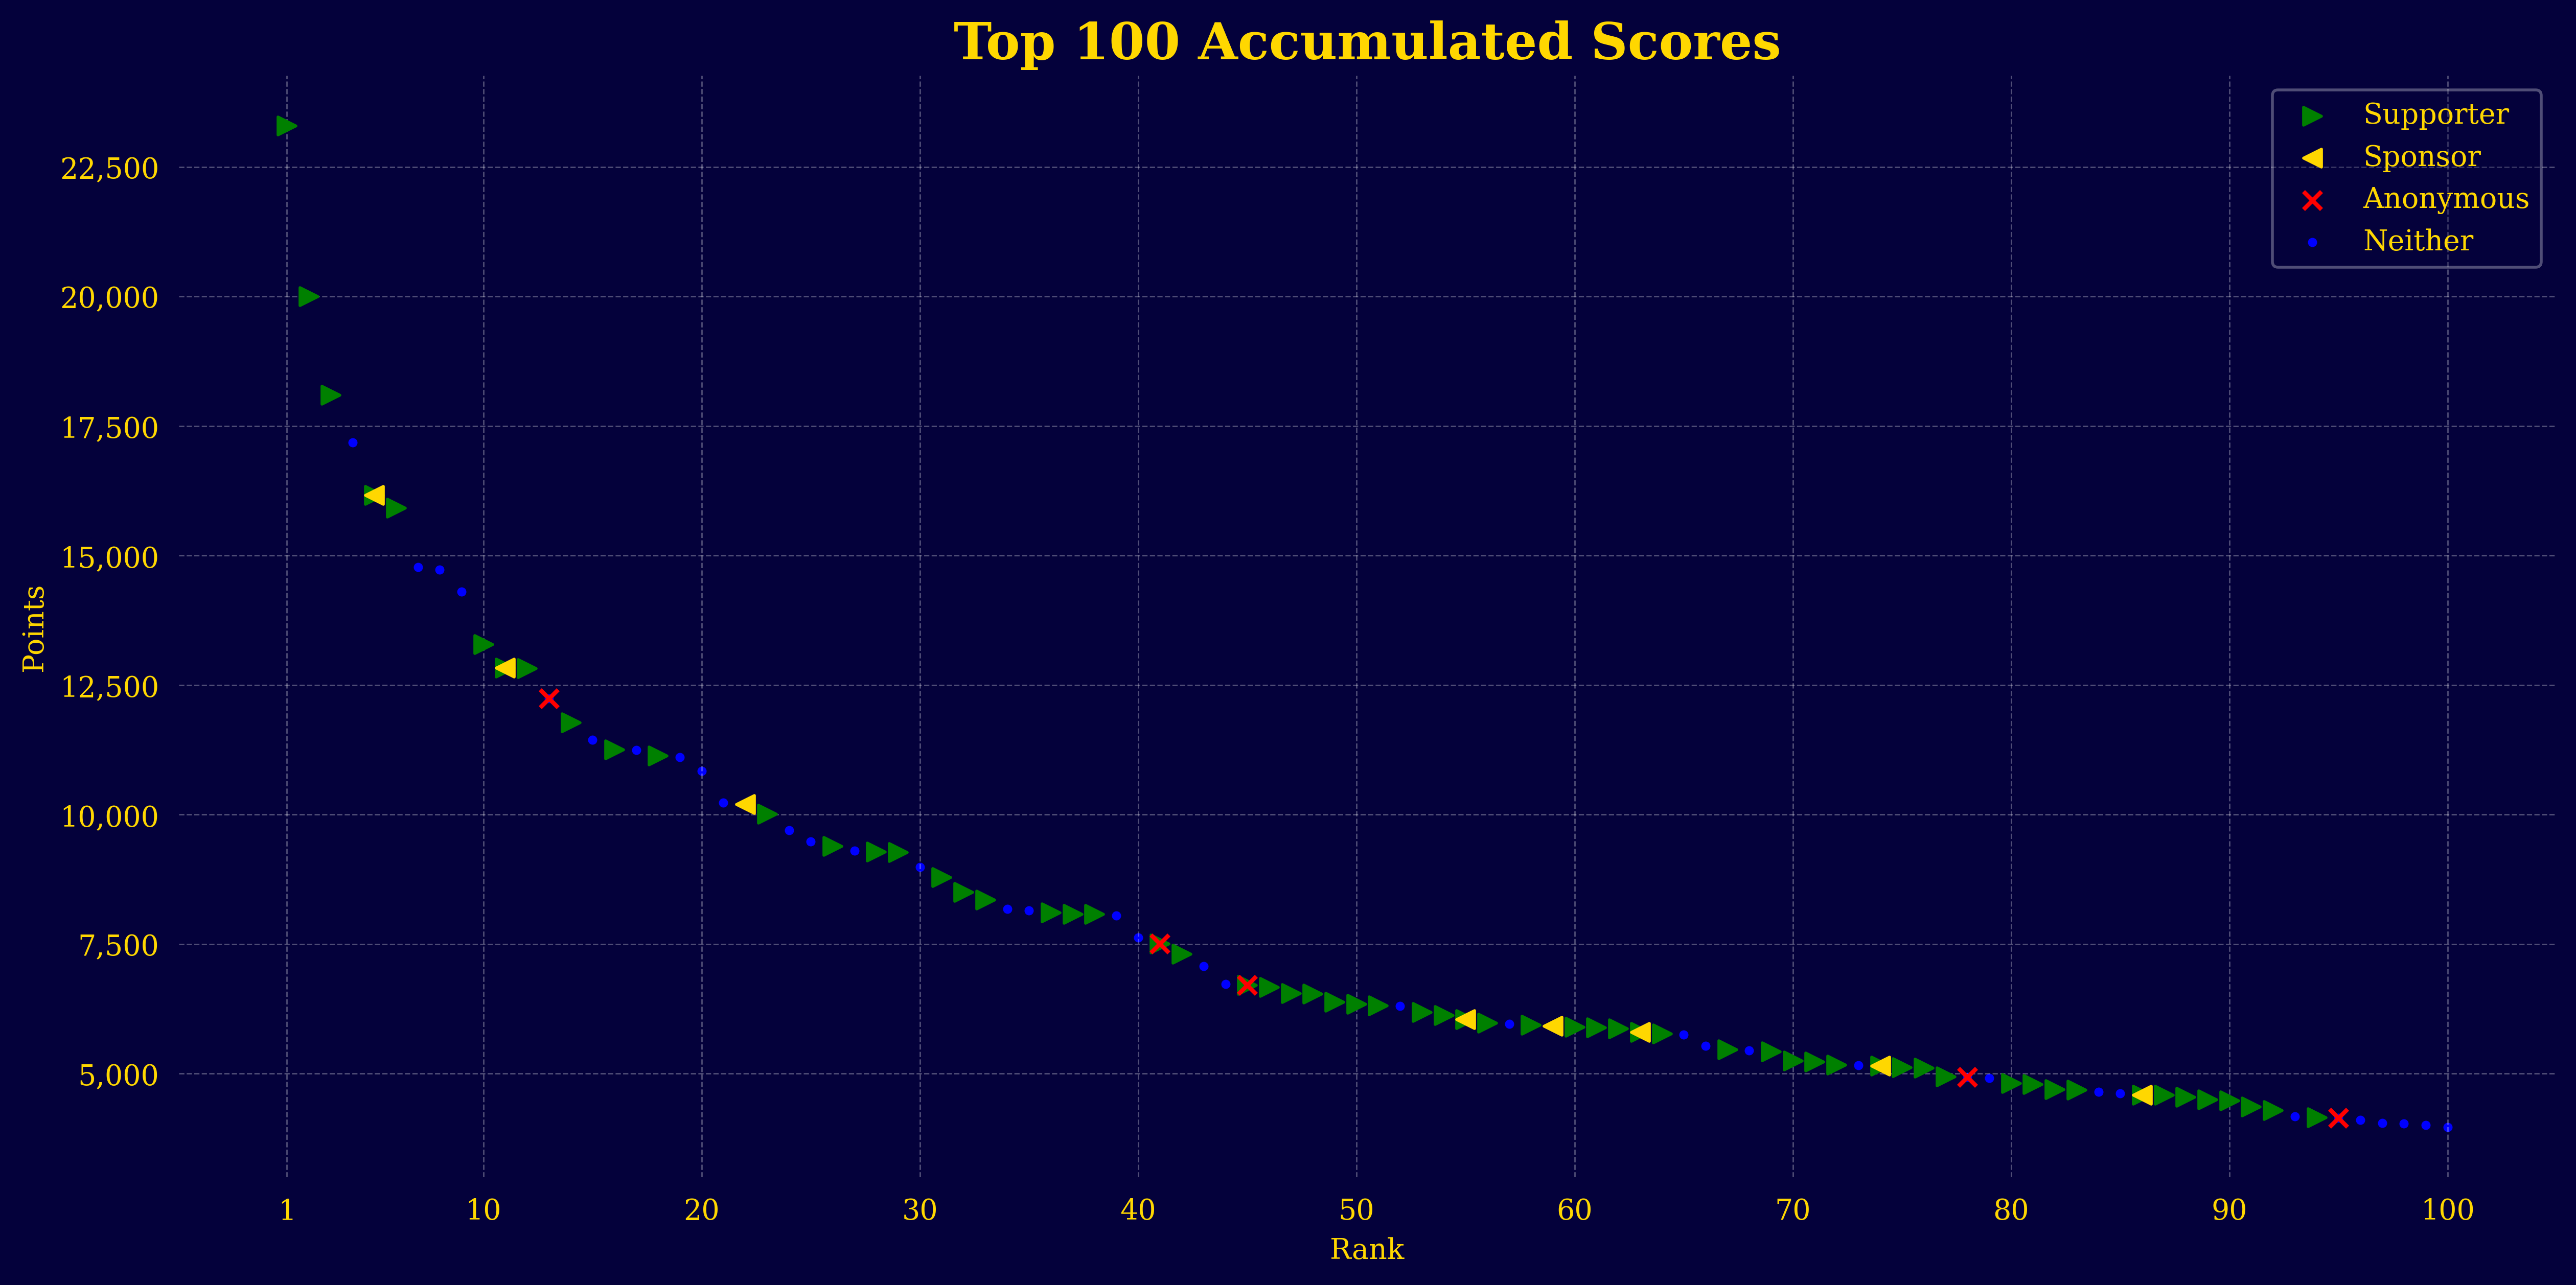

In [7]:
top_100 = users[:100].copy()
top_100['rank'] = range(1, 101)
top_support = top_100[top_100.supporter==True]
top_sponsor = top_100[top_100.sponsor==True]
top_anon = top_100[top_100.anonymous==True]


plt.figure(figsize=(15,7))
plt.scatter(top_support['rank'], top_support['points'], marker='>', c='green', edgecolors='green', s=(s:=40), zorder=2, label='Supporter')
plt.scatter(top_sponsor['rank'], top_sponsor['points'], marker='<', c=TEXT_COLOR, edgecolors=TEXT_COLOR, s=s, zorder=2, label='Sponsor')
plt.scatter(top_anon['rank'], top_anon['points'], marker='x', c=PRIMARY_COLOR, s=s, zorder=2, label='Anonymous')
plt.scatter(range(1, 101), top_100.points, s=5, color='blue', label='Neither')
plt.xticks([1] + list(range(10, 101, 10)))
plt.xlabel('Rank')
plt.ylabel('Points')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title('Top 100 Accumulated Scores')
plt.legend();

if SAVEFIG:
    plt.savefig(TOP100_ACCUMULATED_PLOT)


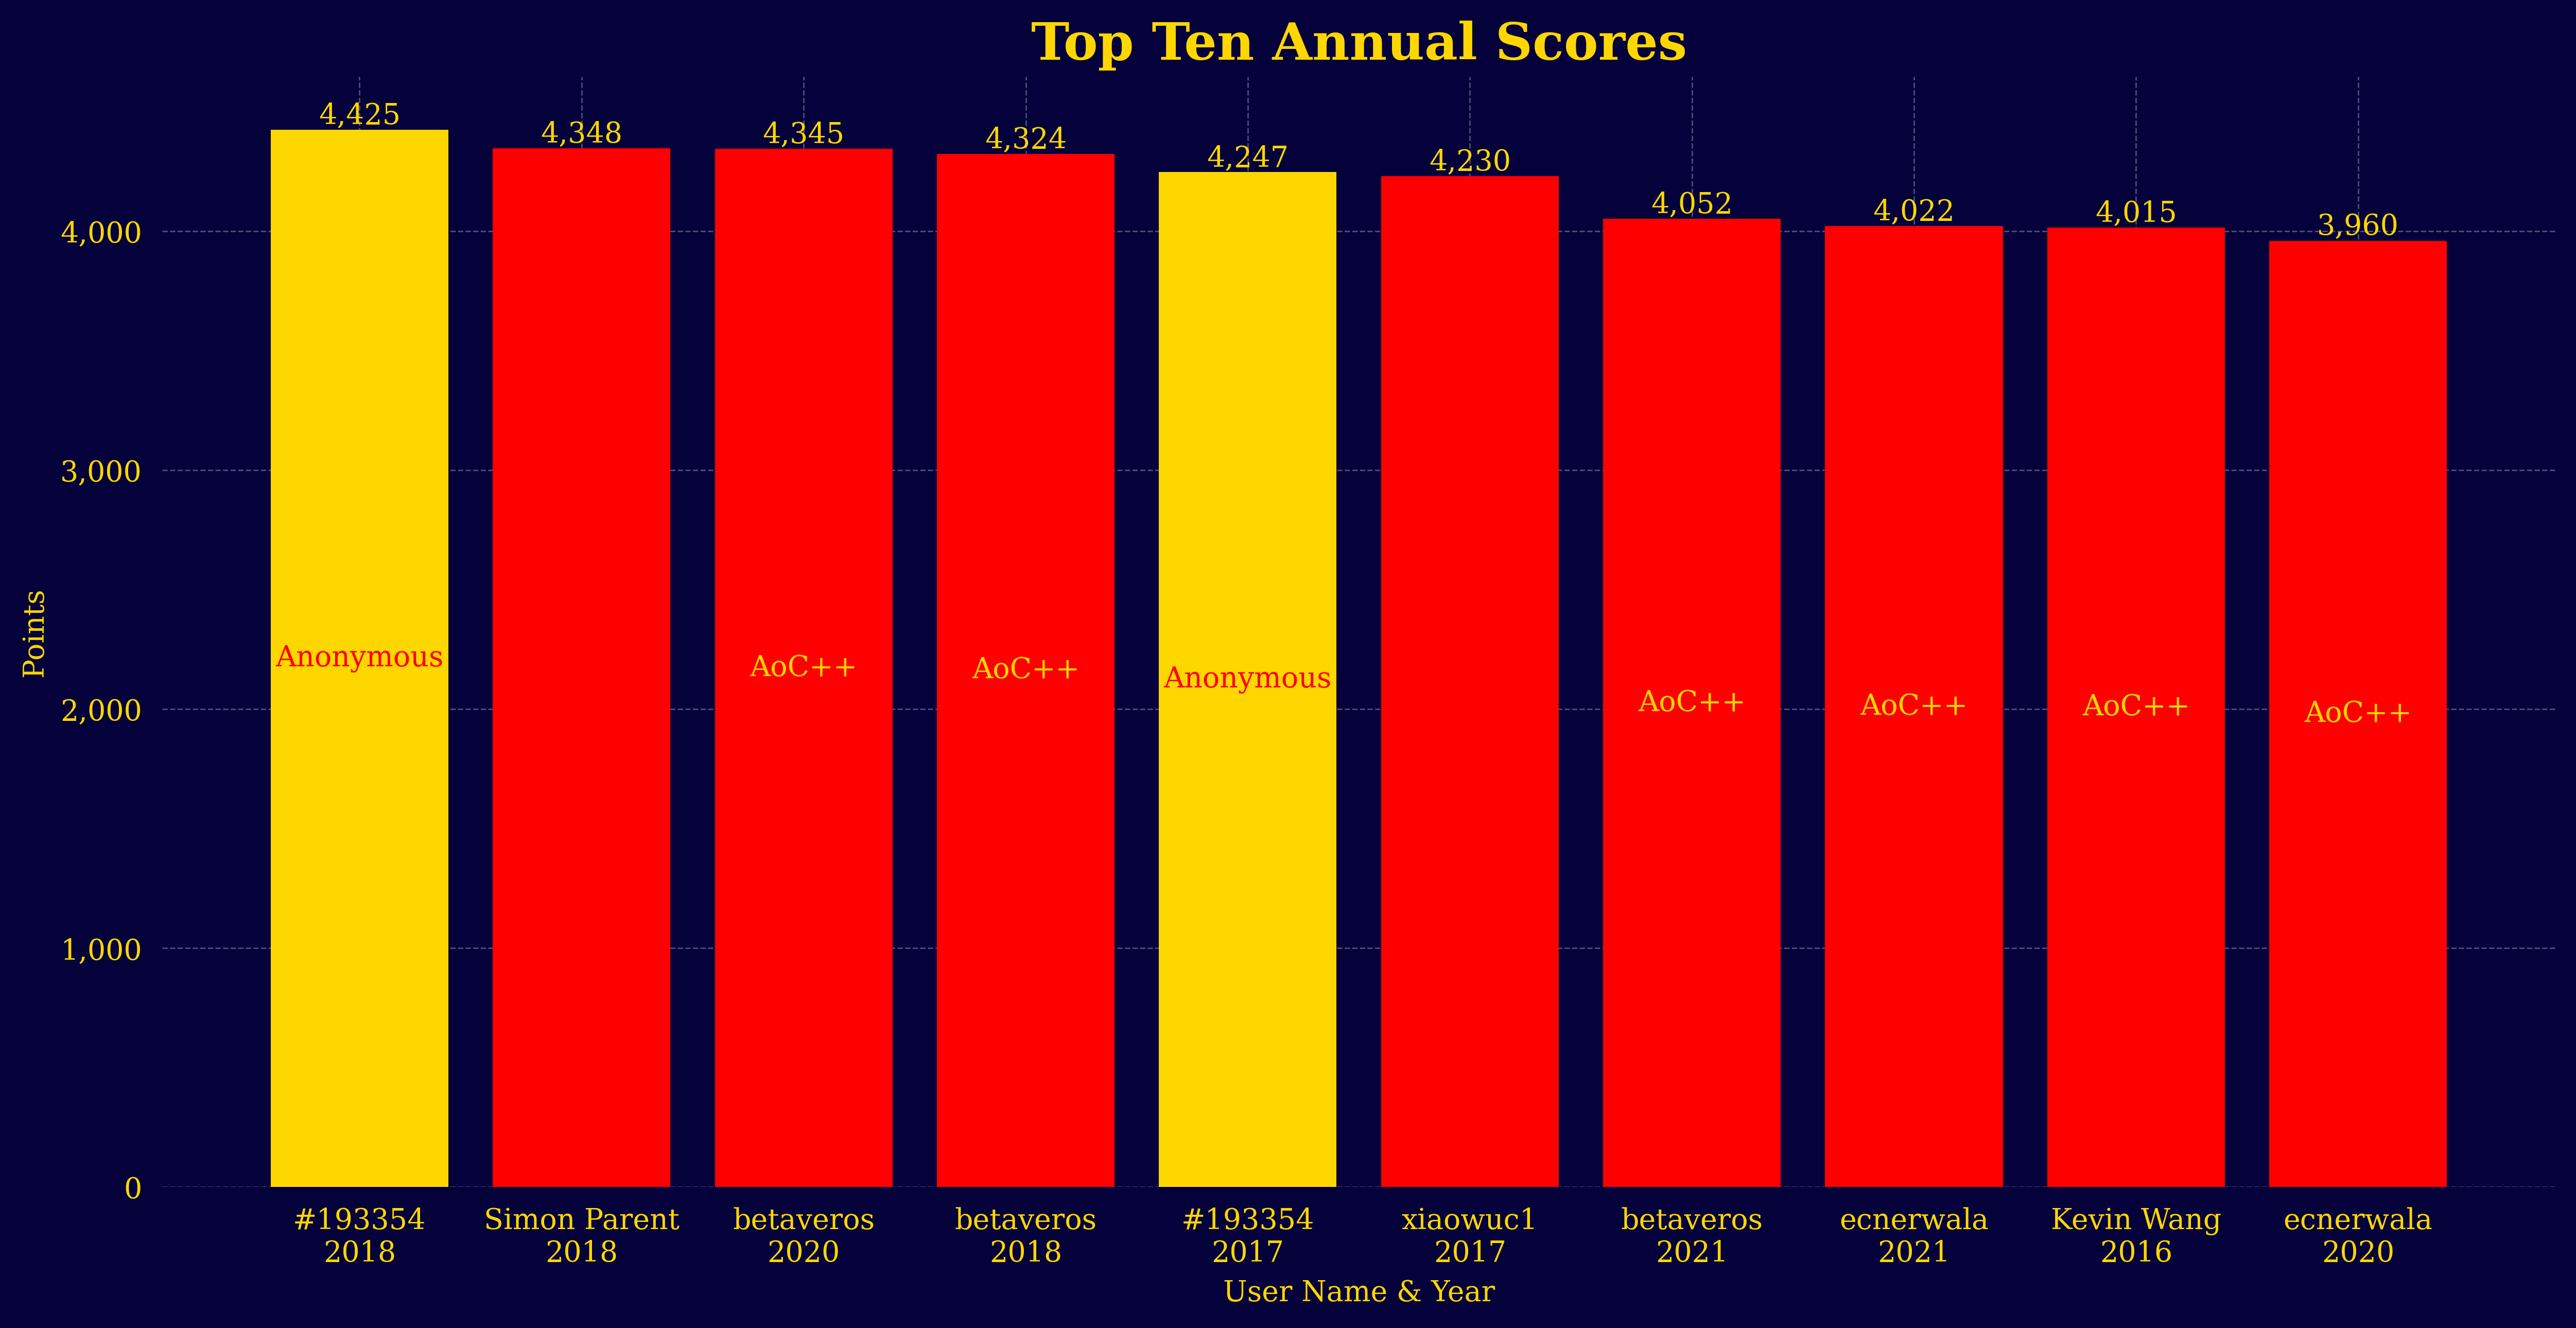

In [8]:
annual_stacked = leaderboard.groupby(['user_name', 'year'])['points'].sum().reset_index()
top_10_annual = annual_stacked.sort_values(by='points', ascending=False).head(10)

xlabels = []
colors = []
tags = []
for i in range(10):
    name, year = top_10_annual.iloc[i, :2]
    
    tag = ''
    if users.loc[name, 'anonymous']:
        tag += 'Anonymous'
    if users.loc[name, 'supporter']:
        tag += 'AoC++'
    if users.loc[name, 'sponsor']:
        tag += 'sponsor'
    tags.append(tag)

    if 'anonymous' in name:
        name = f'{name[16:-1]}'
        colors.append(TEXT_COLOR)
    else:
        colors.append(PRIMARY_COLOR)
    xlabels.append(f'{name}\n{year}')
    
plt.figure(figsize=(15, 7))
plt.title('Top Ten Annual Scores')
bars = plt.bar(range(10), top_10_annual.points, color=colors, zorder=2)
for bar, tag in zip(bars, tags):
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    plt.text(x, y, f'{y:,.0f}', ha='center', va='bottom')
    if tag == 'Anonymous':
        plt.text(x, y/2, tag, color=PRIMARY_COLOR, ha='center', va='center')
    elif tag:
        plt.text(x, y/2, tag, ha='center', va='center')

        
plt.xticks(range(10), labels=xlabels)
plt.xlabel('User Name & Year')
plt.ylabel('Points')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'));

if SAVEFIG:
    plt.savefig(TOP10_ANNUAL_PLOT)

**All Time MVPs**
- For most of AoC's history, **Robert Xiao** has been at the top in terms of total annually accumulated points
- However, **betaveros** has had a very steep rise from 2017 till 2022 and if his trajectory had continued into 2023, he'd be #1 right now
- Everybody in the the top 10 has been competing since at least 2017

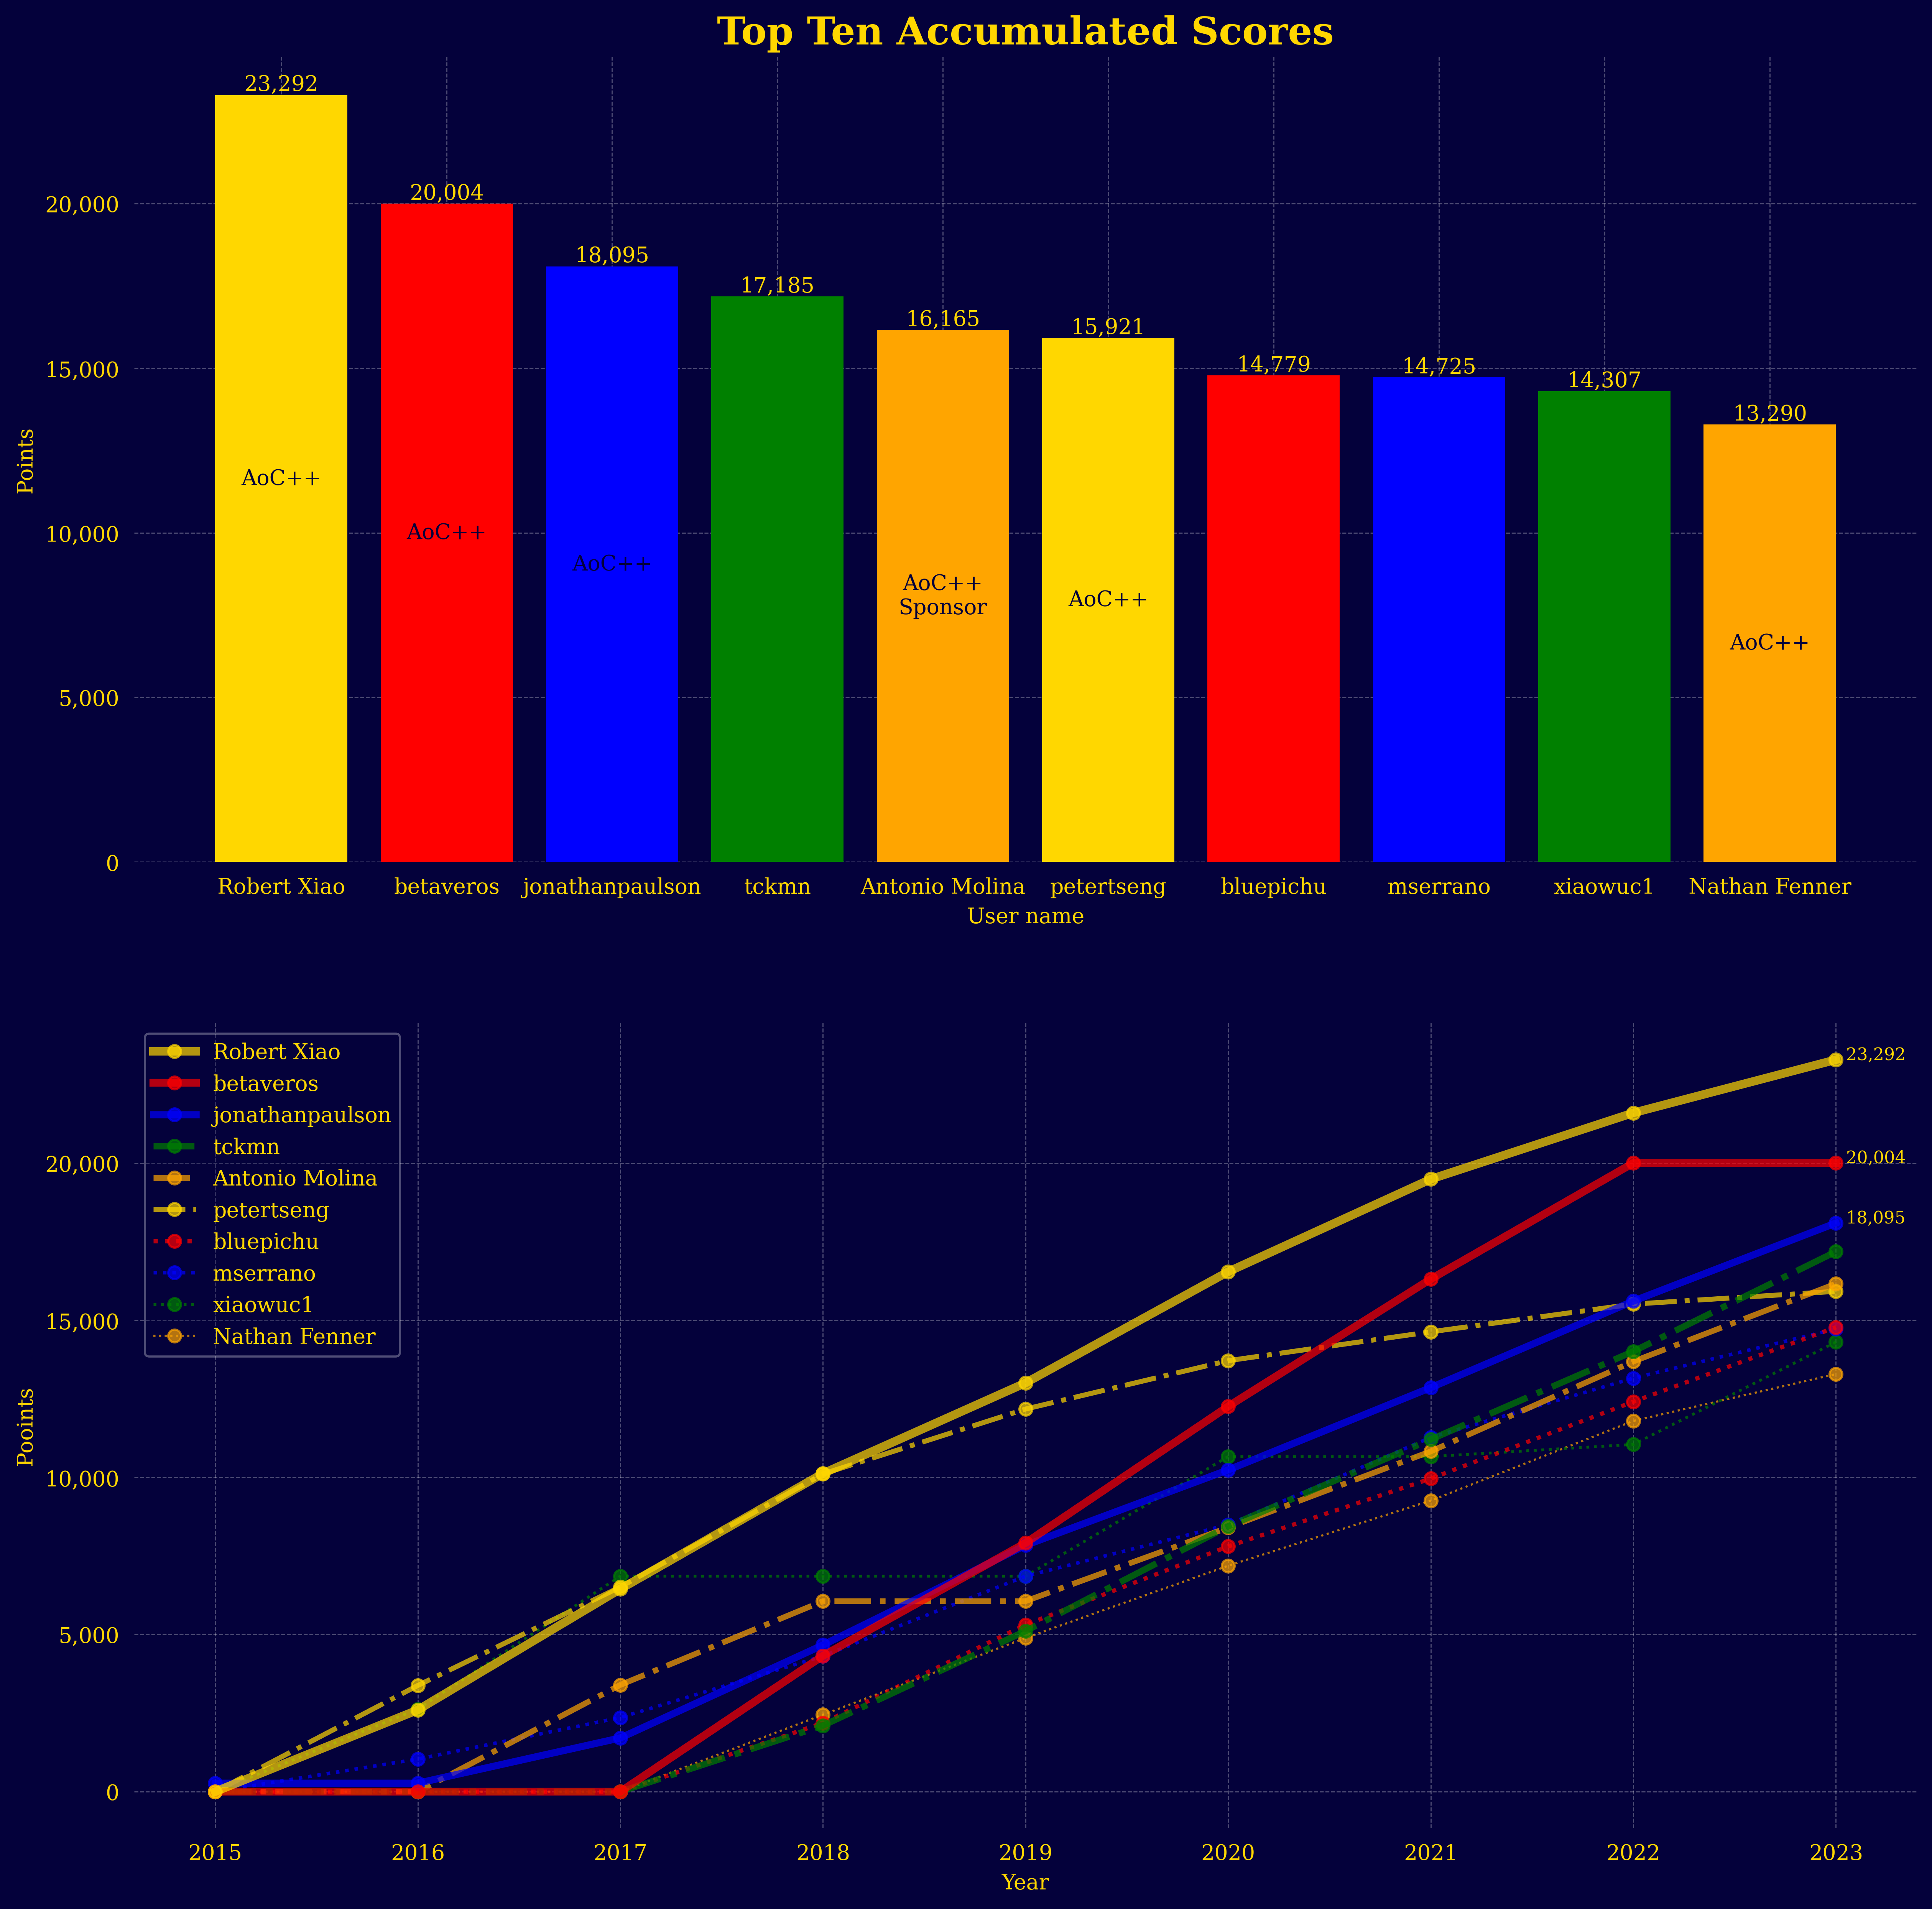

In [9]:
top_ten_final = users.head(10)

annual = leaderboard.groupby(['user_name', 'year'])['points'].sum().reset_index()
annual = annual.pivot(index='year', columns='user_name')
annual.columns = [name for _, name in annual.columns]
annual = annual.fillna(0).astype(int)
annual_cumsum = annual.cumsum()
sorted_cols = annual_cumsum.loc[2023].sort_values().index
top_ten_progress = annual_cumsum[sorted_cols].iloc[:, -10:]
    
ax1, ax2 = plt.subplots(2, 1, figsize=(15, 15))[1]
colors = [TEXT_COLOR, PRIMARY_COLOR, 'blue', 'green', 'orange'] * 2 

bars = ax1.bar(top_ten_final.index, top_ten_final['points'], color=colors, zorder=2)
for bar, name in zip(bars, top_ten_final.index):
    pos = bar.get_x()
    width = bar.get_width()
    score = bar.get_height()
    ax1.text(pos + width/2, score, f'{score:,}', ha='center', va='bottom')  # ha and va represent horizontal and vertical alignment
    if top_ten_final.loc[name, 'supporter'] and top_ten_final.loc[name, 'sponsor']:
        ax1.text(pos + width/2, score/2, 'AoC++\nSponsor', ha='center', va='center', color=BACKGROUND_COLOR)
    elif top_ten_final.loc[name, 'supporter']:
        ax1.text(pos + width/2, score/2, 'AoC++', ha='center', va='center', color=BACKGROUND_COLOR)
    elif top_ten_final.loc[name, 'sponsor']:
        ax1.text(pos + width/2, score/2, 'Sponsor', ha='center', va='center', color=BACKGROUND_COLOR)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.set_xlabel('User name')
ax1.set_ylabel('Points')
ax1.set_title('Top Ten Accumulated Scores')

for i, (name, color) in enumerate(zip(top_ten_progress.columns, reversed(colors))):
    linestyle = ':' if i<4 else '-.' if i<7 else '-'
    label = name 
    ax2.plot(top_ten_progress.index, top_ten_progress[name], label=label, linewidth=1+i*(1/3), alpha=0.7, color=color, marker='o', linestyle=linestyle )
    if i > 6:
        y_final = top_ten_progress.loc[2023, name]
        ax2.text(2023.05, y_final, f'{y_final:,}', fontsize=8)

handles, labels = plt.gca().get_legend_handles_labels()
ax2.legend(reversed(handles), reversed(labels), loc='upper left')
ax2.set_xlabel('Year')
ax2.set_ylabel('Pooints')
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'));

if SAVEFIG:
    plt.savefig(TOP10_ACCUMULATED_PLOT)